In [2]:
import pandas as pd
import numpy as np
import seaborn as sns



def bootstrap(s, nb_boot=10_000):
    "percentile bootstrap of the mean with 95% confidence interval" 
    # we compute the statistic on resamples with replacement 
    x_star = [s.sample(n=len(s), replace=True).mean() for i in range(nb_boot)]

    # 95th confidence interval of the statistic (here the mean)
    return np.percentile(x_star, [2.5, 97.5])


# Revisiting "The importance of individual beliefs in assessing treatment efficacy"
Luisa Fassi, Shachar Hochman, Zafiris J Daskalakis, Daniel M Blumberger, Roi Cohen Kadosh (2024) The importance of individual beliefs in assessing treatment efficacy eLife 12:RP88889 https://doi.org/10.7554/eLife.88889.3
    
## Exploration of Figure 5 (Leffa et al., 2022)

In [8]:
# NOTE: dropout is set to 1 for participants who left the study before the end
# the column Unnamed: 7 is a comment to explain why participant did not answer
# the blinding question whereas they did not left the study. Note that
# dropout can be to 0 (no dropout), but the participant did not answer the blinding.
# The only reliable way to exclude participant with incomplete data is to
# remove all participants with np.nan in the blinding column
df = (pd
      .read_excel("./Data/Leffa_deidentified_2022.xls")
      .drop(columns=['Unnamed: 7', 'dropout'])
      .set_index('subject')
)
# we do not keep participants with no blinding
mask = df.loc[:,'blinding'].isna()
print(f"There are {mask.sum()} participants with no answer to the blinding question")
print(f"The total number of participants is {df.shape[0]}")
df_initial = df.loc[~mask, :]
print(
    "Total number of participants really included in the analysis: ",
    df_initial.shape[0],
)
df = (
    df_initial
    .rename(
        columns={"treatment": "Objective treatment", "blinding": "Subjective treatment"}
    )
    .melt(
        id_vars=["casrs_a_1", "casrs_a_3"],
        value_vars=["Objective treatment", "Subjective treatment"],
        var_name="Treatment type",
        # value_name="Subjective treatment",
    )
    .melt(id_vars=["Treatment type", "value"], value_vars=["casrs_a_1", "casrs_a_3"], var_name="Week", value_name='CASRS score')
)
df.loc[:, "Week"] = df.loc[:, "Week"].replace(
    {"casrs_a_1": "Week 1", "casrs_a_3": "Week 3"}
)

There are 11 participants with no answer to the blinding question
The total number of participants is 64
Total number of participants really included in the analysis:  53


The total number of participants really included in the analysis is 53. Let see how many participants per group we have.

In [14]:
df_initial.groupby(["treatment", "blinding"])["casrs_a_1"].count().unstack()

blinding,active,sham
treatment,,
active,16,9
sham,13,15


So the groups size are quite small and imbalanced

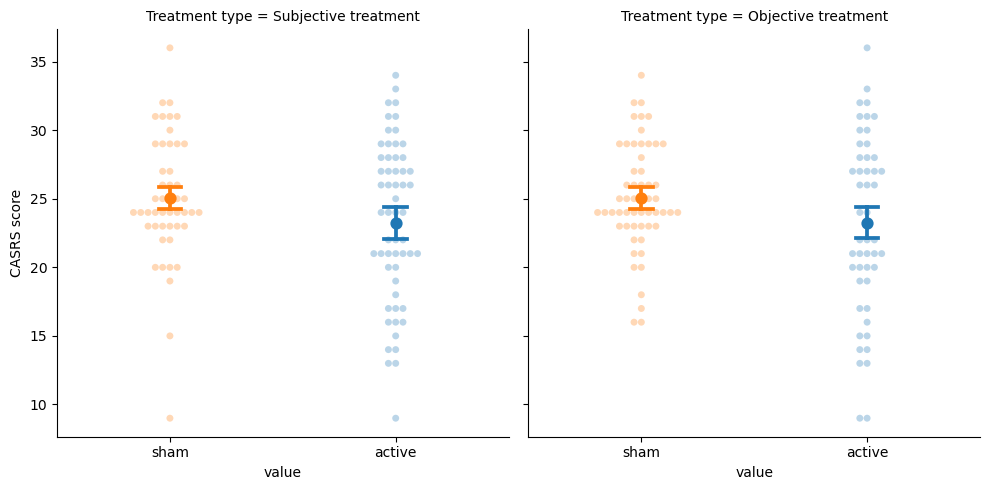

In [110]:
g = sns.catplot(
        data=df,
        x="value",
        y="CASRS score",
        col="Treatment type",
        hue="value",
        kind="swarm",
        col_order=["Subjective treatment", "Objective treatment"],
        order=["sham", "active"],
        alpha=0.3
    )


for ax in g.axes.flat:
    sns.pointplot(
        data=df,
        x="value",
        y="CASRS score",
        hue="value",
        order=["sham", "active"],
        estimator="mean",
        errorbar=("ci", 95),
        # errorbar=("se"),
        n_boot=10000,
        capsize=0.1,
        ax=ax,
    )

We have reproduced Figure 5,but with a 95% percentile bootstrap confidence interval. Let's see below the exact interval.

In [15]:
df.groupby(['Treatment type', 'value'])['CASRS score'].apply(bootstrap).unstack()

value,active,sham
Treatment type,,
Objective treatment,"[21.28, 24.8]","[24.071428571428573, 26.089285714285715]"
Subjective treatment,"[21.913793103448278, 24.862068965517242]","[23.666666666666668, 26.291666666666668]"


There is one suprising decision in the analysis. They mix the CASRS score asked in week 1 and in week 3. I am not sure it is a sound decision. Interestingly, if we only take results from week 3, we have a more convincing difference between sham and active (see below).

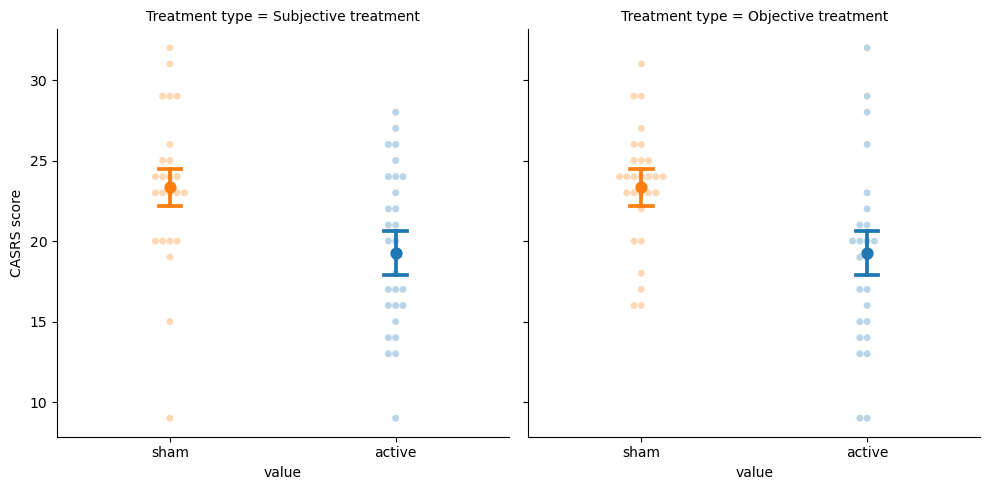

In [17]:
mask = df.loc[:,'Week'] == 'Week 3'
df2= df.loc[mask, :]
g = sns.catplot(
    data=df2,
    x="value",
    y="CASRS score",
    col="Treatment type",
    hue="value",
    kind="swarm",
    col_order=["Subjective treatment", "Objective treatment"],
    order=["sham", "active"],
    alpha=0.3,
)


for ax in g.axes.flat:
    sns.pointplot(
        data=df2,
        x="value",
        y="CASRS score",
        hue="value",
        order=["sham", "active"],
        estimator="mean",
        errorbar=("ci", 95),
        # errorbar=("se"),
        n_boot=10000,
        capsize=0.1,
        ax=ax,
    )

In [18]:
df2.groupby(["Treatment type", "value"])["CASRS score"].apply(bootstrap).unstack()

value,active,sham
Treatment type,,
Objective treatment,"[16.72, 21.16]","[22.035714285714285, 24.714285714285715]"
Subjective treatment,"[17.79310344827586, 21.310344827586206]","[21.291666666666668, 25.291666666666668]"
